# Practical Session 5 - Parallel Markov chains with multiprocessing and dask

Students (pair):
- [Alexandre LECOMTE](https://github.com/tribulle)
- [Serina TRAORE](https://github.com/username2)


**Useful references for this lab**:

[1] `seaborn`: [official tutorial](https://seaborn.pydata.org/tutorial.html)

[2] `multiprocessing`: [documentation](https://docs.python.org/3/library/multiprocessing.html), [doc2](https://he-arc.github.io/livre-python/multiprocessing/index.html)

[3] `dask`: [documentation](http://numba.pydata.org/) 

## <a name="content">Contents</a>
- [Exercise 1: seaborn, a useful tool for data visualisation](#ex1)
- [Exercise 2: Simulating a discrete-time homogeneous Markov chain](#ex2)
- [Bonus: Parallel computing with Dask](#bonus)
---

In [2]:
%load_ext autoreload
%autoreload 2

## <a name="ex1">Exercise 1: seaborn, a useful tool for data visualisation</a> [(&#8593;)](#content)
 
The `seaborn` package can significantly enhance data and data analysis visualization. See the [tutorial page](https://seaborn.pydata.org/tutorial.html) for examples of effective predefined graphics. An example aimed at visualizing the empirical distributions of 9 realizations of a bivariate Gaussian random vector is reported below.

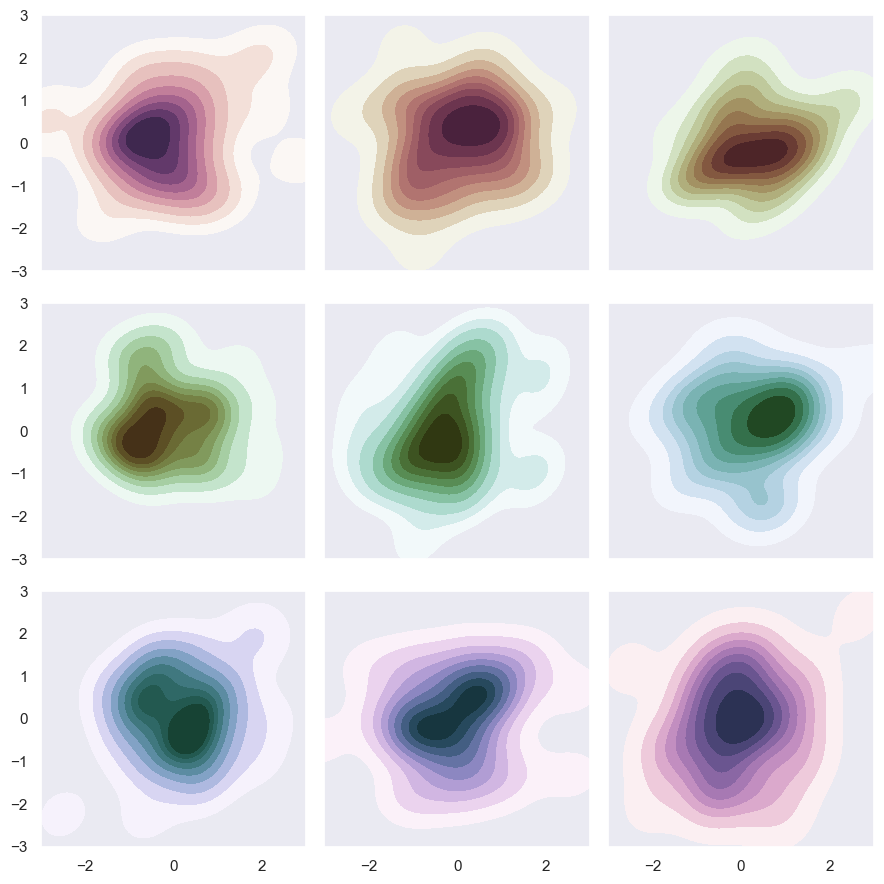

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set(style="dark")
rng = np.random.default_rng(50)

# Set up the matplotlib figure
f, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True)

# Rotate the starting point around the cubehelix hue circle
for ax, s in zip(axes.flat, np.linspace(0, 3, 10)):

    # Create a cubehelix colormap to use with kdeplot
    cmap = sns.cubehelix_palette(start=s, light=1, as_cmap=True)

    # Generate and plot a random bivariate dataset
    x, y = rng.normal(size=(2, 50))
    sns.kdeplot(x=x, y=y, cmap=cmap, fill=True, cut=5, ax=ax)
    ax.set(xlim=(-3, 3), ylim=(-3, 3))

f.tight_layout()

1. Comment on the lines of codes related to the `seaborn` library to make their role explicit. More specifically comment on the KDE method.

**Answer:**

La méthode **KDE** (Estimation de Densité à Noyau) dans Seaborn, utilisée via `sns.kdeplot(x=x, y=y)`, est une technique non paramétrique permettant d'estimer la fonction de densité de probabilité d'une variable aléatoire à partir de données échantillonnées. Elle lisse la distribution des points en générant une courbe qui représente leur densité dans un espace bidimensionnel, ce qui est utile pour visualiser des distributions bivariées. En spécifiant des paramètres comme `cmap`, une palette de couleurs (ici issue de `cubehelix`) est appliquée pour indiquer visuellement les zones de haute et basse densité. L'option `fill=True` remplit la surface sous les courbes de densité, rendant le graphique plus intuitif et visuellement attrayant. Le paramètre `cut=5` permet d'étendre les tracés au-delà de la plage des données réelles pour une estimation plus large. Enfin, `ax=ax` est utilisé pour spécifier le sous-graphe où dessiner le tracé, ce qui est particulièrement utile lorsque plusieurs graphiques sont tracés simultanément dans une grille.

2. For one of the realizations, take a look at the documentation of [`sns.jointplot`](https://seaborn.pydata.org/examples/joint_kde.html) to display both the 2-D empirical distribution of the data, and 1D histograms of their distribution along each axis. 

**Answer:**

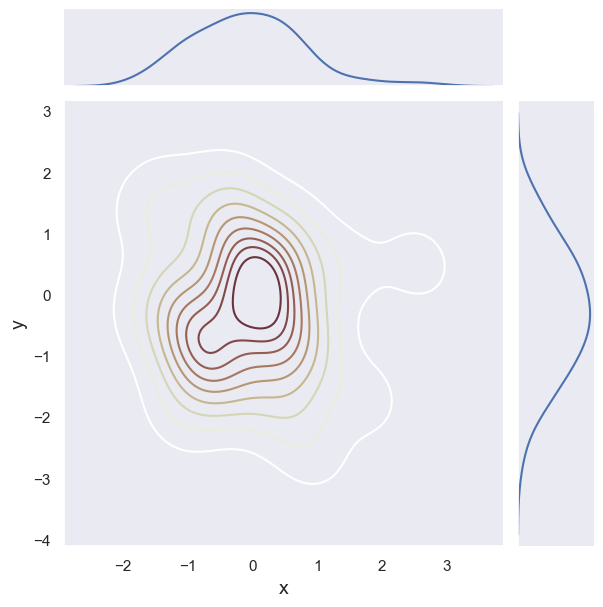

In [2]:
x, y = rng.normal(size=(2, 50))
cmap = sns.cubehelix_palette(start=0.5, light=1, as_cmap=True)
sns.jointplot(x=x, y=y, kind='kde', cmap=cmap)

plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.show()


## <a name="ex2">Exercise 2: Simulating a discrete-time homogeneous Markov chain.</a> [(&#8593;)](#content)


Let ${(X_n)}_{n\geq 0}$ be a discrete-time homogeneous Markov chain with values over a finite ensemble $E=\{x_1,\dots,x_N\}$ identified to $\{1,\dots,N\}$. Consider $\boldsymbol{\rho} \in \Delta_N$, where $\Delta_N = \{\mathbf{x}\in\mathbb{R}^N \mid x_n \geq 0 \, \forall n \in \{1,\dotsc,N\} \text{ and } \sum_n x_n = 1 \}$ is the unit simplex in $\mathbb{R}^N$.

In the following, we consider the initial state of the chain $X_0$, following the discrete probability distribution:

$$
    \mathbb{P}(X_0 = k) = \rho_k, \qquad k \in \{1, \dots,  N\}.
$$
  
Let $\mathbf{A} = [a_{i,j}]_{i,j} \in \mathbb{R}^{N \times N}$ be the transition matrix of the chain, i.e.,

\begin{align*}
    &a_{i,j} = \mathbb{P}(X_{n+1} = j \mid X_{n} = i) \geq 0, \, \forall n \geq 0, \\
    &(\forall i \in \{1, \dotsc, N\}), \quad \sum_{j=1}^N a_{i,j} = 1.
\end{align*}
 
The chain is said to be homogeneous in that $\mathbf{A}$ does not depend from the time index $n$. Let $\tilde{a}_n$ represent the $n$-th row of $\mathbf{A}$. 

The trajectory of the chain can be simulated as follows:

>- Draw the discrete random variable $X_0$ with distribution $\boldsymbol{\rho}$;
>
>- For $q = 0$ to $n_{\text{iter}}-1$
>    - Draw the discrete random variable $X_{q+1}$ with distribution $\tilde{a}_{X_{q}}$;
>    
>- Return ${(X_q)}_{0 \leq q \leq n_{\text{iter}}}$.


<!-- If $X_n = k$, we know that $T$, the life time of the chain in the state $k$ obeys a geometric distribution with parameter $a_{kk}$. We also know that the probability of transition from k to $\ell\neq k$ is given by:

$$
    \mathbb{P}(X_{n+1}=\ell | X_n=k, \ell\neq k) = \frac{a_{k\ell}}{1-a_{kk}}.
$$

 ### One possible algorithm to simulate a Markov chain is therefore:

    a. generate the initial state $X_0$ according to the discrete law $\{\rho_1,\dots,\rho_N\}$.

    b. at instant $n$, knowing that $X_n=k$,

    i) determine the life time $T$ in state $X_n=k$ by simulating a geometrical variable with parameter $a_{kk}$. As a consequence $X_n = \dots = X_{n+T} = k$. When $T=0$, we simply still have $X_n=k$.

    ii) determine next transition instant $n+T$, and determine the next state by using the probabilities of transition. -->

1. Implement the above algorithm in a function `X = markov(rho,A,nmax,rng)` with:
     - `rho`: law of the initial state (nonnegative vector of size $N$, summing to 1),
     - `A`: transition matrix (of size $N\times N$) 
     - `nmax`: number of time steps,
     - `rng`: random number generator
     - `X`: trajectory of the chain.
     
In particular, check the input parameters `A` and `rho` make sense by adding appropriate assertions (or raising exceptions).
   - Examples : **transition matrix `A` should be square** ; **expected `A` to be a stochastic matrix** ; **verify if the size of `A` and `rho` are consistent** ; **verify if `rho` is in the unit simplex**
     - `np.allclose`, `np.isclose` and `np.all` could be useful

> Hints:
> - the function `np.random.choice` can be useful to draw discrete random variables.
> - use `states = np.arange(N)` to create the the labels of the states (from $0$ up to $N-1$)

Here is an example of execution : 
![alternatvie text](img/For_CourseM.png)

**Answer:**

In [3]:
def markov(rho, A, nmax, rng):

    ####################### Tests
    A_shape = A.shape
    assert A_shape[0] == A_shape[1]
    N = A_shape[0]
    assert N == rho.shape[0]
    assert np.isclose(np.sum(rho), 1)
    assert np.allclose(np.sum(A, axis=1), 1)
    #########################

    states = np.arange(N)

    X_list = np.zeros(nmax + 1, dtype=int)
    X_list[0] = rng.choice(states, p = rho.flatten())

    for q in range(1, nmax + 1):
        current_state = X_list[q-1]
        X_list[q] = np.random.choice(states, p = A[current_state])

    return X_list

2. Set the random number generator to a known state. Make a few simulations using simple transition matrices (*i.e.*, taking any nonnegative matrix $A=(a_{i,j})$ such that its lines sum to 1) and display the trajectory of the chains.

**Answer:**

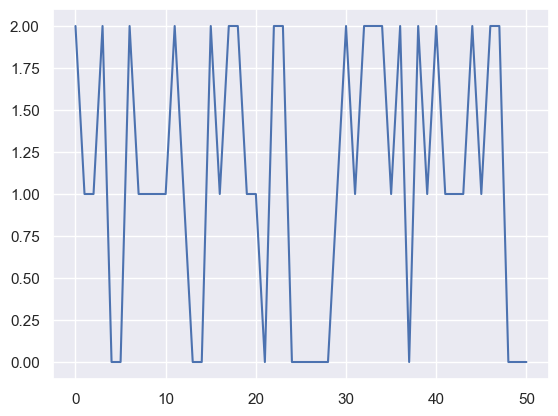

In [4]:
# Test
rng = np.random.default_rng(seed=42)

# Matrice de transition A
A = np.random.rand(3, 3)
A = A / A.sum(axis=1)[:, None]  # Normalisation de A pour que chaque ligne somme à 1

# Vecteur de probabilité initiale rho
rho = np.array([[0],
                [0],
                [1]])
#rho = np.random.rand(3, 1)


nmax = 50

# Appel de la fonction
trajectory = markov(rho, A, nmax, rng)
plt.grid()
plt.plot(range(nmax + 1), trajectory)
plt.show()

3. Explore the potential of the [`multiprocessing` package](https://docs.python.org/3/library/multiprocessing.html) to simulate several Markov chains in parallel.

> Hint: the `mutiprocessing.Pool.starmap` or `mutiprocessing.Pool.starmap_async` methods could be useful.

**Answer:**

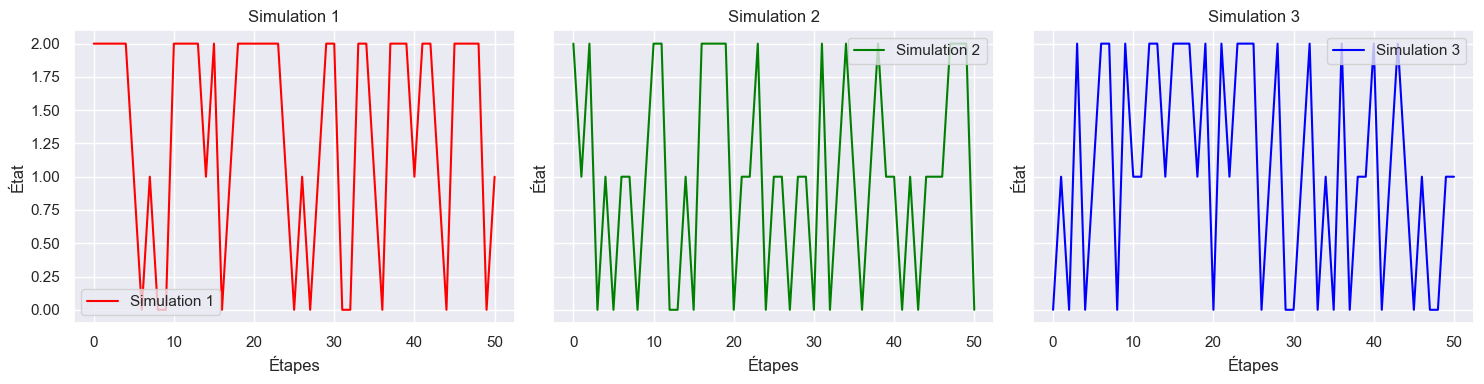

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
from multiprocessing import Pool
from markov_simulations import markov  # Importer depuis le fichier externe

def setup_simulations():
    nmax = 50
    seed = 42

    A1 = np.random.rand(3, 3)
    A1 = A1 / A1.sum(axis=1)[:, None]

    A2 = np.random.rand(3, 3)
    A2 = A2 / A2.sum(axis=1)[:, None]

    A3 = np.random.rand(3, 3)
    A3 = A3 / A3.sum(axis=1)[:, None]

    rho1 = np.array([[0], [0], [1]])
    rho2 = np.random.rand(3, 1)
    rho2 = rho2 / rho2.sum()
    rho3 = np.array([[1], [0], [0]])


    rng1 = np.random.default_rng(seed)
    rng2 = np.random.default_rng(seed + 1)
    rng3 = np.random.default_rng(seed + 2)

    # Préparation des simulations avec le générateur de nombres aléatoires
    simulations = [
        (rho1, A1, nmax, rng1),
        (rho2, A2, nmax, rng2),
        (rho3, A3, nmax, rng3)
    ]
    return simulations


colors = {
    0: 'red',
    1: 'green',
    2: 'blue'
}


fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

# Encapsulation correcte du code multiprocessing
if __name__ == '__main__':

    # Récupération des simulations
    simulations = setup_simulations()

    # Utilisation de Pool pour paralléliser les simulations
    with Pool(processes=3) as pool:  # Utilisation correcte de Pool
        results = pool.starmap(markov, simulations)

    # Affichage des résultats
    for i, trajectory in enumerate(results):
        axes[i].plot(range(len(trajectory)), trajectory, label=f'Simulation {i + 1}', color=colors[i])
        axes[i].set_title(f'Simulation {i + 1}')
        axes[i].set_xlabel("Étapes")
        axes[i].set_ylabel("État")
        axes[i].grid(True)
        axes[i].legend()

    plt.tight_layout()
    plt.show()


4. [Bonus] Generate Markov chains in parallel with the [`dask`](https://docs.dask.org/en/latest/futures.html) library, which offers more general parallelization functionalities (with, for instance, the use of [`Futures`](https://docs.dask.org/en/stable/futures.html), see tutorial [here](https://tutorial.dask.org/05_futures.html)). A useful example is provided [here](https://stackoverflow.com/questions/41471248/how-to-efficiently-submit-tasks-with-large-arguments-in-dask-distributed). Note that `dask` is much more versatile and powerful than `multiprocessing`, and can be useful to scale algorithms over multiple cores and/or computing nodes.

**Answer:**

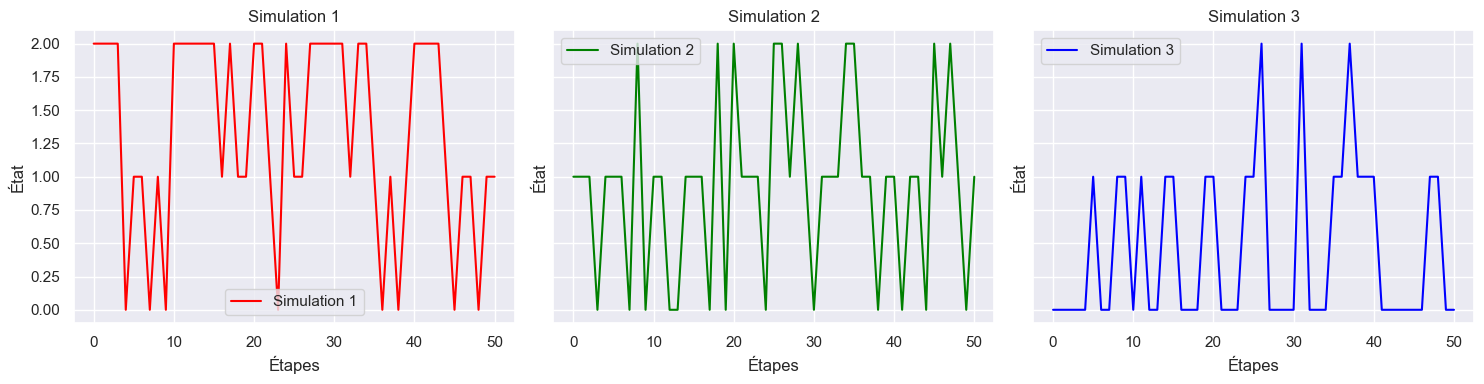

In [6]:
import dask
from dask import delayed
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

simulations = setup_simulations()

#Lazy
delayed_results = [delayed(markov)(*params) for params in simulations]
#Calculs
results = dask.compute(*delayed_results)

# Affichage des résultats
for i, trajectory in enumerate(results):
    axes[i].plot(range(len(trajectory)), trajectory, label=f'Simulation {i + 1}', color=colors[i])
    axes[i].set_title(f'Simulation {i + 1}')
    axes[i].set_xlabel("Étapes")
    axes[i].set_ylabel("État")
    axes[i].grid(True)
    axes[i].legend()

plt.tight_layout()
plt.show()

## <a name="bonus">Bonus: Parallel computing with Dask</a> [(&#8593;)](#content)

1. Take a look at the [`dask.array` documentation](https://docs.dask.org/en/stable/array-best-practices.html) and the associate [tutorial](https://tutorial.dask.org/02_array.html). Apply some of the functions introduced herein and in the [documentation](https://docs.dask.org/en/stable/array-best-practices.html) to parallelize the computation of the total variation investigated during session 2. Note that you can combine `dask` and `numba` to obtain an overall more efficient implementation. Note that timing can be worse than Numpy (`dask.array` is more specifically interesting when the data do no fit in memory).

2. Take a look at the [`dask.delayed` tutorial](https://tutorial.dask.org/03_dask.delayed.html), and go through some of the examples provided. [Best practices with the `dask.delayed` interface](https://docs.dask.org/en/stable/delayed-best-practices.html) are summarized in the documentation.

> **Remark**: an alternative to Dask: the [Ray](https://docs.ray.io/en/latest/) library.

**Answer:**

In [15]:
import dask.array as da
import numpy as np

#Même fonction mais avec Dask.array à la place de Numpy.array
def gradient2D(X):
    """This function computes D(.)

    Args:
        X (dask.array): the matrix for which we compute D(.)

    Returns:
        (dask.array, dask.array): the couple (XDh, DvX) which is equal to D(X)
    """
    assert len(X[0].shape) <= 2  # En dimension 2
    if len(X.shape) >= 2 and X.shape[0] >= 2:  # Si ce n'est pas un vecteur colonne
        XDh = da.concatenate([X[:, 1:], X[:, -1:]], axis=1) - X
    else:
        XDh = da.zeros_like(X)

    if len(X.shape) >= 2 and X.shape[1] >= 2:  # Si ce n'est pas un vecteur colonne
        DvX = (da.concatenate([X.T[:, 1:], X.T[:, -1:]], axis=1) - X.T).T
    else:
        DvX = da.zeros_like(X)
    return (XDh, DvX)

def TV(X):
    """Computes the norm for D(.)

    Args:
        X (dask.array): The matrix for which we compute the norm of D(X)

    Returns:
        (float): the value of the norm
    """
    XDh, DvX = gradient2D(X)
    
    # Calculer la norme élément par élément
    norm_elements = da.sqrt(XDh**2 + DvX**2)

    # Calculer la somme de toutes les normes
    return norm_elements.sum().compute()

# Test 1 with a random matrix
R = np.array([
    [4, 2,],
    [3, 10,],
])

dask_R = da.from_array(R, chunks=(1, 2))

assert TV(dask_R) == np.sqrt(2**2+1**2) + np.sqrt(8**2+0) + np.sqrt(7**2) + 0

# Test 2 with a "constant" matrix
R = np.ones((3, 3))
dask_R = da.from_array(R, chunks=(1, 2))
assert TV(dask_R) == 0

Dask.delayed n'est pas utile ici, si on utilise Daks.array